# Ressources

In [1]:
import pandas as pd
import numpy as np
import missingno
from IPython.display import display, Image
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots

from pycaret.classification import *

# fix pour plotly express et Visual Studio Code
import plotly.io as pio
pio.renderers.default = "notebook_connected"

import matplotlib.pyplot as plt
import seaborn as sns

from imblearn.over_sampling import SMOTE, SMOTENC
from sklearn.impute import SimpleImputer
from sklearn.feature_selection import SelectFromModel
import re

from imblearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV, train_test_split

from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer

import plotly.figure_factory as ff
import gc

# Garbage collection is to release memory when the object is no longer in use. This system destroys the unused object and reuses its memory slot for new objects. You can imagine this as a recycling system in computers.

import shap

import time
from contextlib import contextmanager

from lightgbm import LGBMClassifier
import lightgbm as lgb
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.model_selection import KFold, StratifiedKFold

from rich.console import Console

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

# Fonctions
## Data

In [2]:

def comparaisons_colonnes(df1:pd.DataFrame, df2:pd.DataFrame):
    """Compare les colonnes de deux DF, et renvoient celles qui ne sont pas présentes dans les deux fichiers.

    Parameters
    -----------
    df1: :class:`DataFrame`

    df2: :class:`DataFrame`

            
    Return
    ----------
    Deux listes avec la différence dans le DataFrame 1 puis le DataFrame 2
    
    Exemples
    ----------
    list_1 = list(df_2015.columns)
    
    list_2 = list(df_2016.columns)

    dif1, dif2 = comparaisons_colonnes(df1, df2)
    """
    
    list_1 = list(df1.columns)
    list_2 = list(df2.columns)
    # Un set est un ensemble de clefs non ordonnées et non redondant où l'on peut savoir
    # si un élément est présent sans avoir à parcourir toute la liste (une sorte de dictionnaire où les valeurs seraient ignorées, seules les clefs comptent).
    dif_list_1_list_2 = list(set(list_1) - set(list_2))
    dif_list_2_list_1 = list(set(list_2) - set(list_1))
    nb_dif_list1_list_2 = len(dif_list_1_list_2)
    nb_dif_list2_list1 = len(dif_list_2_list_1)
    print(f'Colonnes présentes dans le df1, absentes dans le df2 ({nb_dif_list1_list_2}) : {dif_list_1_list_2}')
    print(f'Colonnes présentes dans le df2, absentes dans le df1 ({nb_dif_list2_list1}) : {dif_list_2_list_1}')
    

    
def identification_colonne_binaire(df, var_ignore=None):
    
    df_identif = df.copy()
    if var_ignore != None:
        df_identif.drop([var_ignore], axis=1, inplace=True)
    nb_cols = df_identif.shape[1]
    col_binaire_name = []
    col_binaire_number = []
    for i in range(0, nb_cols):
        len_colonne = len(df_identif.iloc[:,i].value_counts())
        
        if len_colonne == 2:
            col_binaire_name.append(df_identif.iloc[:,i].name)
            col_binaire_number.append(i)
            
            
            
    print(f'Colonnes binaires : {col_binaire_name}')
    print(f'Nombres : {len(col_binaire_number)}')
    
    return col_binaire_name, col_binaire_number


def identification_colonne_categorique(df, var_ignore=None, nb_valeurs_unique=2):
    
    df_identif = df.copy()
    if var_ignore != None:
        df_identif.drop([var_ignore], axis=1, inplace=True)
    nb_cols = df_identif.shape[1]
    col_binaire_name = []
    col_binaire_number = []
    for i in range(0, nb_cols):
        len_colonne = len(df_identif.iloc[:,i].value_counts())
        
        if nb_valeurs_unique == 2:
            if len_colonne == nb_valeurs_unique:
                col_binaire_name.append(df_identif.iloc[:,i].name)
                col_binaire_number.append(i)
                df_identif.iloc[:,i] = df_identif.iloc[:,i].astype('object')
        else:
            if len_colonne <= nb_valeurs_unique:
                col_binaire_name.append(df_identif.iloc[:,i].name)
                col_binaire_number.append(i)
                df_identif.iloc[:,i] = df_identif.iloc[:,i].astype('object')
            
            
    if var_ignore != None:
        df_identif[var_ignore] = df[var_ignore]
            
            
    print(f'Nombres de colonnes avec {nb_valeurs_unique} valeurs uniques : {len(col_binaire_number)}')
    
    return df_identif

### Corrélation

In [3]:
def correlation_independante_et_dependante(df:pd.DataFrame, colonne:str, title:str):
        
        """Corrélation entre des variables indépendantes avec une variable dépendante.
        Renvoie une heatmap en une seule colonne

    Parameters
    -----------
    df: :class:`DataFrame`
            Le DataFrame
    colonne: :class:`str`
            La variable dépendante, où on va juger les corrélations des autres variables
    title: :class:`str`
            Titre du graphique
            
    Return
    ----------
    Graphique
    """
        
        f, ax = plt.subplots(figsize=(11, 20))

        heatmap = sns.heatmap(df.corr()[[colonne]].sort_values(by=colonne, ascending=False), annot=True)
        
        heatmap.set_title(title, fontdict={'fontsize':18}, pad=16);

# Data formatée

In [4]:
# fichier application_test avec uniquement l'id et Target

data_test_clean = pd.read_csv('submission_kernel02.csv')
data_test_clean.rename(columns={'TARGET' : 'PROBA_TARGET'}, inplace=True)
data_test_clean

# Target = La probabilité prédite pour chaque classe pour chaque échantillon. Pourquoi dans un dataset séparé ?

,SK_ID_CURR,PROBA_TARGET
0,100001,0.034300
1,100005,0.146855
2,100013,0.027505
3,100028,0.038554
4,100038,0.153569
...,...,...
48739,456221,0.046247
48740,456222,0.060781
48741,456223,0.008308
48742,456224,0.026186


In [5]:
# Fichier application_train fusionnée
data_results = pd.read_csv('data_featured.csv')


In [6]:
data_results

,index,SK_ID_CURR,TARGET,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,...,CC_NAME_CONTRACT_STATUS_Signed_MAX,CC_NAME_CONTRACT_STATUS_Signed_MEAN,CC_NAME_CONTRACT_STATUS_Signed_SUM,CC_NAME_CONTRACT_STATUS_Signed_VAR,CC_NAME_CONTRACT_STATUS_nan_MIN,CC_NAME_CONTRACT_STATUS_nan_MAX,CC_NAME_CONTRACT_STATUS_nan_MEAN,CC_NAME_CONTRACT_STATUS_nan_SUM,CC_NAME_CONTRACT_STATUS_nan_VAR,CC_COUNT
0,0,100002,1.0,0,0,0,0,202500.0,406597.5,24700.5,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1,100003,0.0,1,0,1,0,270000.0,1293502.5,35698.5,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2,100004,0.0,0,1,0,0,67500.0,135000.0,6750.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,3,100006,0.0,1,0,0,0,135000.0,312682.5,29686.5,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,6.0
4,4,100007,0.0,0,0,0,0,121500.0,513000.0,21865.5,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
356246,48739,456221,NaN,1,0,0,0,121500.0,412560.0,17473.5,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
356247,48740,456222,NaN,1,0,1,2,157500.0,622413.0,31909.5,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
356248,48741,456223,NaN,1,1,0,1,202500.0,315000.0,33205.5,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
356249,48742,456224,NaN,0,0,1,0,225000.0,450000.0,25128.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


## Choix de features


Nous avons 800 colonnes, on peut donc vite s'y perdre...


- Selection des features
- Gestion des NaN (essayer de les compléter ou ignorer)
- Cross validation
- SMOTE (sur le dataset d'entrainement)

### Commun

In [7]:
train_df_test = data_results[data_results['TARGET'].notnull()] # Target présent
test_df_test = data_results[data_results['TARGET'].isnull()] # Target NA

print(f"Train : {train_df_test.shape}")
print(f"Test : {test_df_test.shape}")



# Il y a des valeurs infinies dans le data_temp_x, on remplace par 0 (à voir ...)
if np.all(np.isfinite(train_df_test)) == False:
    train_df_test.replace([np.inf, -np.inf], np.nan, inplace=True)
    
# fix LGBM

# Fix LightGBMError do not support special Json character in feature name (Kevin). On remplace:
train_df_test = train_df_test.rename(columns = lambda x:re.sub('[^A-Za-z0-9_]+', '', x))

Train : (307507, 797)
Test : (48744, 797)


### Test avec Pycaret
Jamais utilisé pycaret... Test par curiosité

https://pycaret.gitbook.io/docs/get-started/functions/deploy#predict_model

#### Preprocessing avec simpleImputer

In [8]:
test1 = setup(data=train_df_test, target="TARGET", use_gpu=True, feature_selection=True, memory="D:/Pycaret/", session_id=6443, n_features_to_select=20)

KeyboardInterrupt: 

In [ ]:
data_transform_train = get_config('X_train')
display(data_transform_train)

data_transform_test = get_config('X_test')
display(data_transform_test)

data_transform = test1.dataset_transformed

,CODE_GENDER,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_ID_PUBLISH,EXT_SOURCE_1,EXT_SOURCE_2,EXT_SOURCE_3,INCOME_CREDIT_PERC,PAYMENT_RATE,ACTIVE_DAYS_CREDIT_MAX,PREV_CNT_PAYMENT_MEAN,APPROVED_CNT_PAYMENT_MEAN,INSTAL_DPD_MEAN,INSTAL_AMT_PAYMENT_SUM,INSTAL_DAYS_ENTRY_PAYMENT_MAX,INSTAL_DAYS_ENTRY_PAYMENT_MEAN,CC_CNT_DRAWINGS_ATM_CURRENT_MEAN
0,1.0,545040.0,26640.0,450000.0,18557.0,-1408.000000,-2107.0,0.762222,0.597050,0.510920,0.169143,0.048877,-417.020353,4.500000,6.000000,0.139130,2.974154e+05,-9.000000,-1622.756470,0.035294
1,0.0,305221.5,20524.5,252000.0,16495.0,-286.000000,-9.0,0.501657,0.323226,0.165407,0.130314,0.067245,-280.000000,6.000000,6.000000,1.571429,9.702306e+04,-591.000000,-664.857117,0.567980
2,1.0,119358.0,5872.5,85500.0,23417.0,-2379.364757,-4210.0,0.501657,0.313428,0.707699,0.065250,0.049201,-245.000000,14.333333,14.333333,1.476923,5.380365e+05,-46.000000,-1155.861572,0.567980
3,1.0,396850.5,12159.0,279000.0,11885.0,-1290.000000,-2598.0,0.131353,0.716288,0.170446,0.090067,0.030639,-149.000000,14.515557,13.583127,1.060397,6.767255e+05,-328.511135,-921.481106,0.567980
4,0.0,509602.5,19539.0,387000.0,18219.0,-171.000000,-1673.0,0.501657,0.678702,0.657784,0.144733,0.038342,-417.020353,20.500000,11.333333,0.270270,6.954078e+05,-207.000000,-826.621643,0.567980
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
215249,0.0,225000.0,19242.0,225000.0,10353.0,-2029.000000,-2975.0,0.501657,0.614096,0.627991,0.185913,0.085520,-407.000000,11.000000,11.000000,1.692308,1.929480e+05,-37.000000,-577.923096,0.567980
215250,1.0,942300.0,26041.5,675000.0,15971.0,-3110.000000,-4442.0,0.501657,0.709088,0.520898,0.144675,0.027636,-49.000000,15.000000,15.000000,0.843750,3.345442e+05,-767.000000,-1139.031250,0.567980
215251,1.0,1546020.0,42642.0,1350000.0,19436.0,-2379.364757,-2976.0,0.667261,0.331750,0.363945,0.201617,0.027582,-1395.000000,17.000000,17.000000,0.000000,1.099706e+06,-160.000000,-1468.769287,0.567980
215252,0.0,270000.0,13500.0,270000.0,13152.0,-1468.000000,-3928.0,0.279631,0.631666,0.510920,0.066667,0.050000,-636.000000,12.000000,12.000000,4.451613,2.035709e+05,-254.000000,-857.032288,0.567980


,CODE_GENDER,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_ID_PUBLISH,EXT_SOURCE_1,EXT_SOURCE_2,EXT_SOURCE_3,INCOME_CREDIT_PERC,PAYMENT_RATE,ACTIVE_DAYS_CREDIT_MAX,PREV_CNT_PAYMENT_MEAN,APPROVED_CNT_PAYMENT_MEAN,INSTAL_DPD_MEAN,INSTAL_AMT_PAYMENT_SUM,INSTAL_DAYS_ENTRY_PAYMENT_MAX,INSTAL_DAYS_ENTRY_PAYMENT_MEAN,CC_CNT_DRAWINGS_ATM_CURRENT_MEAN
215254,1.0,942300.0,27679.5,675000.0,17375.0,-4641.000000,-922.0,0.583062,0.008678,0.576209,0.227815,0.029374,-193.000000,8.666667,8.666667,0.156028,5.911048e+05,-14.000000,-1657.943237,0.072917
215255,1.0,1349910.0,48618.0,1192500.0,20022.0,-10355.000000,-3571.0,0.605937,0.595112,0.145543,0.263512,0.036016,-84.000000,11.142858,10.000000,0.000000,1.304288e+06,-489.000000,-953.764709,0.567980
215256,1.0,193572.0,20668.5,171000.0,19337.0,-2516.000000,-2863.0,0.602138,0.735479,0.436507,0.114825,0.106774,-664.000000,20.285715,20.285715,0.204545,2.617448e+06,-40.000000,-907.034119,0.567980
215257,1.0,675000.0,19345.5,675000.0,22271.0,-2379.364757,-3983.0,0.501657,0.572947,0.510920,0.286600,0.028660,-276.000000,6.000000,6.000000,0.000000,3.640100e+04,-274.000000,-308.666656,0.567980
215258,0.0,1288350.0,34114.5,1125000.0,15556.0,-7460.000000,-1771.0,0.501657,0.702810,0.654529,0.151620,0.026479,-831.000000,14.515557,13.583127,1.060397,6.767255e+05,-328.511135,-921.481106,0.567980
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
307502,1.0,808650.0,26217.0,675000.0,19579.0,-1106.000000,-3064.0,0.501657,0.758687,0.799297,0.145650,0.032421,-595.000000,14.515557,13.583127,1.060397,6.767255e+05,-328.511135,-921.481106,0.567980
307503,1.0,254700.0,20119.5,225000.0,11794.0,-4685.000000,-3869.0,0.641289,0.448945,0.107532,0.263000,0.078993,-123.000000,8.666667,8.666667,1.571429,3.060724e+05,-17.000000,-486.485718,3.200000
307504,0.0,353241.0,23737.5,319500.0,14513.0,-530.000000,-4643.0,0.501657,0.097461,0.510920,0.131875,0.067199,-417.020353,12.000000,12.000000,0.000000,9.428409e+04,-109.000000,-926.250000,0.567980
307505,1.0,239418.0,23454.0,211500.0,24630.0,-2379.364757,-4523.0,0.501657,0.262258,0.538863,0.347467,0.097963,-336.000000,12.000000,12.000000,0.000000,5.151765e+05,-28.000000,-691.142883,0.567980


In [ ]:
# Metrics pour la comparaison
get_metrics()

,Name,Display Name,Score Function,Scorer,Target,Args,Greater is Better,Multiclass,Custom
ID,,,,,,,,,
acc,Accuracy,Accuracy,<function accuracy_score at 0x000001DDE4818C10>,accuracy,pred,{},True,True,False
auc,AUC,AUC,<function roc_auc_score at 0x000001DDE47FBB50>,"make_scorer(roc_auc_score, needs_proba=True, e...",pred_proba,"{'average': 'weighted', 'multi_class': 'ovr'}",True,True,False
recall,Recall,Recall,<pycaret.internal.metrics.BinaryMulticlassScor...,"make_scorer(recall_score, average=weighted)",pred,{'average': 'weighted'},True,True,False
precision,Precision,Prec.,<pycaret.internal.metrics.BinaryMulticlassScor...,"make_scorer(precision_score, average=weighted)",pred,{'average': 'weighted'},True,True,False
f1,F1,F1,<pycaret.internal.metrics.BinaryMulticlassScor...,"make_scorer(f1_score, average=weighted)",pred,{'average': 'weighted'},True,True,False
kappa,Kappa,Kappa,<function cohen_kappa_score at 0x000001DDE4818...,make_scorer(cohen_kappa_score),pred,{},True,True,False
mcc,MCC,MCC,<function matthews_corrcoef at 0x000001DDE4818...,make_scorer(matthews_corrcoef),pred,{},True,True,False


In [ ]:
best = compare_models(sort="AUC", exclude=['gpc', 'rbfsvm', 'mlp'], turbo=False) 

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
catboost,CatBoost Classifier,0.9195,0.7673,0.0247,0.5356,0.0472,0.0403,0.1019,17.9930
lightgbm,Light Gradient Boosting Machine,0.9193,0.7658,0.0251,0.5074,0.0478,0.0405,0.0990,13.5380
gbc,Gradient Boosting Classifier,0.9195,0.7602,0.0177,0.5378,0.0342,0.0292,0.0864,69.2440
xgboost,Extreme Gradient Boosting,0.9185,0.7577,0.0451,0.4505,0.0820,0.0683,0.1224,13.4340
ada,Ada Boost Classifier,0.9192,0.7522,0.0228,0.4881,0.0435,0.0366,0.0918,24.6740
lda,Linear Discriminant Analysis,0.9189,0.7376,0.0183,0.4413,0.0351,0.0288,0.0763,13.1470
et,Extra Trees Classifier,0.9194,0.7305,0.0049,0.6372,0.0097,0.0085,0.0503,17.7180
rf,Random Forest Classifier,0.9194,0.7301,0.0093,0.5390,0.0183,0.0156,0.0626,22.7780
qda,Quadratic Discriminant Analysis,0.8948,0.7055,0.1381,0.2374,0.1732,0.1217,0.1272,12.9510
lr,Logistic Regression,0.9193,0.6325,0.0000,0.0000,0.0000,-0.0000,-0.0002,56.1180


Processing:   0%|          | 0/69 [00:00<?, ?it/s]

Résultat :

Un modèle dont les prédictions sont 100% fausses a une AUC de 0,0 ; un modèle dont les prédictions sont 100% correctes a une AUC de 1,0.

La précision est une métrique très couramment utilisée, même dans la vie de tous les jours. 

A l'opposé de cela, l'AUC n'est utilisé que lorsqu'il s'agit de problèmes de classification avec probabilités afin d'analyser plus en profondeur la prédiction.

---------

Comme nous l'avons déjà mentionné, la métrique AUC utilise des probabilités de prédiction de classe. Sur cette base, nous sommes en mesure d'évaluer et de comparer plus précisément les modèles.

Par exemple, supposons que nous ayons deux modèles de classification binaires A et B qui ont une précision de 95 %. Le modèle A prédit toutes les classes classées avec précision avec une probabilité d'environ 60 %, tandis que le modèle B a pour certaines classes classées avec précision une probabilité supérieure à 90 %. Il est clair qu'ils ont tous les deux la même précision mais le modèle B est plus convaincu dans sa prédiction.

Pour cette raison, pour certains échantillons futurs, il est plus probable que le modèle B aura également une précision plus élevée.

De plus, en utilisant les probabilités et l'AUC, nous pouvons calibrer les seuils de probabilité et améliorer encore plus nos modèles. Ainsi, notre recommandation est la métrique AUC car elle utilise la probabilité des prédictions.

Src : https://www.baeldung.com/cs/ml-accuracy-vs-auc

10 features  :

<center><img src="./img/compare_modele.png" width="800" height="500" /></center>

20 features :

<center><img src="./img/compare_modele_20features.png" width="800" height="500" /></center>

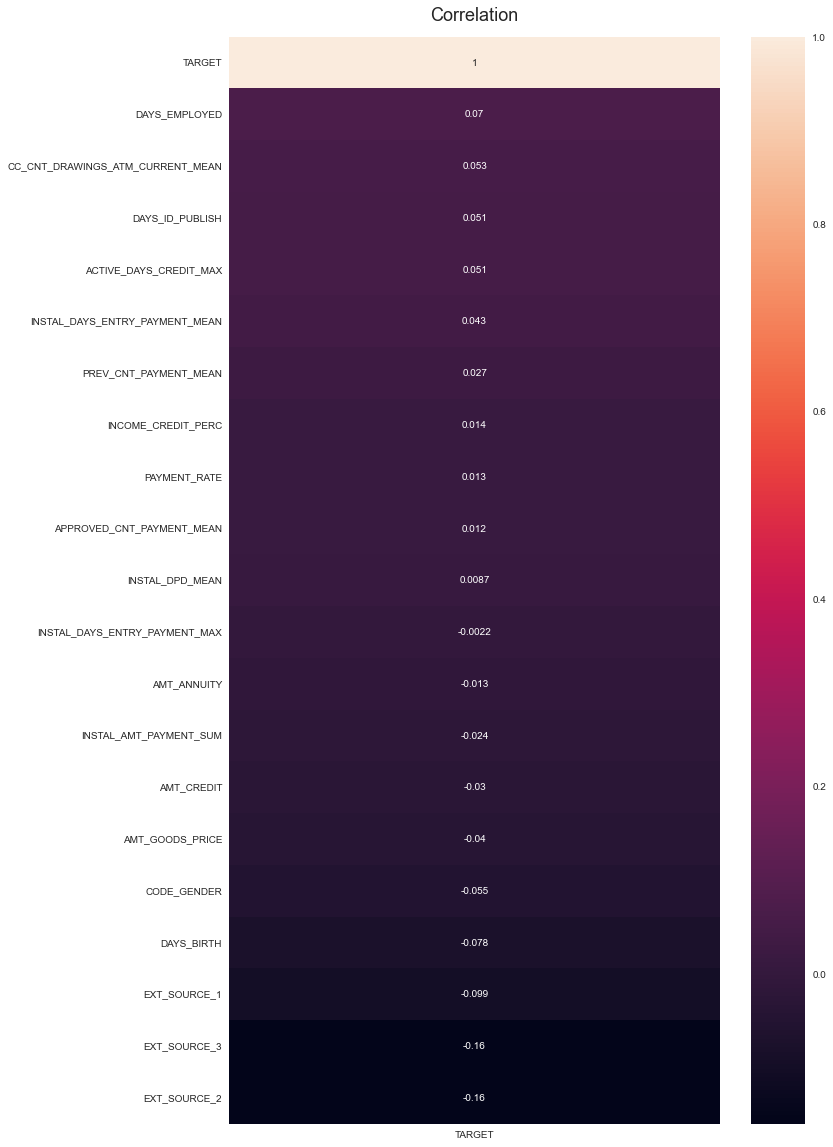

In [ ]:
correlation_independante_et_dependante(data_transform, 'TARGET', 'Correlation')

### Fix Unbalanced 

L'accuracy et l'AUC sont très différents.
Cela implique que le training set a une distribution inégale des valeurs de Target, qui peut être fixé via SMOTE.

SMOTe génère des individus fictifs pour rebalancer le TARGET en densifiant les individus minoritaires de façon homogène.



#### Distribution de la variable Target

In [ ]:
def distribution_target(train_df_test):
    distrib_target = train_df_test['TARGET'].value_counts()  / len(train_df_test['TARGET'])*100


    # fig = px.histogram(train_df_test, x="TARGET", color="TARGET", text_auto=True)

    # fig.show()

    fig = make_subplots(rows=1, cols=2, subplot_titles=("Distribution", "Répartition"),
                            specs=[[{"type": "xy"}, {"type": "domain"}]])

    cat0 = train_df_test[train_df_test['TARGET']==0]['TARGET']
    cat1 = train_df_test[train_df_test['TARGET']==1]['TARGET']

    # fig.add_trace(go.Histogram(x=train_df_test['TARGET']), row=1, col=1)
    fig.add_trace(go.Histogram(x=cat0, name="0", text=str(cat0.count())), row=1, col=1)
    fig.add_trace(go.Histogram(x=cat1, name="1", text=str(cat1.count())), row=1, col=1)
    fig.add_trace(go.Pie(values=distrib_target.values), row=1, col=2)


    fig.update_layout(height=500, showlegend=False, title_text="TARGET")

    #x axis    
    fig.update_xaxes(visible=False)

    fig.show()
    
distribution_target(train_df_test)

#### Test de correction avec lightbgm (class balanced)

In [ ]:
# test
# vérifier qu'il soit focus sur l'auc

# notebook de test qu'on garde sur le côté
bgm_custom= create_model('lightgbm', class_weight="balanced")

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.7158,0.7680,0.6726,0.1740,0.2765,0.1701,0.2306
1,0.7117,0.7675,0.6847,0.1738,0.2772,0.1704,0.2333
2,0.7154,0.7618,0.6743,0.1741,0.2767,0.1702,0.2312
3,0.7152,0.7718,0.6881,0.1763,0.2807,0.1745,0.2379
4,0.7086,0.7505,0.6523,0.1666,0.2654,0.1570,0.2143
5,0.7190,0.7733,0.6834,0.1776,0.2819,0.1764,0.2387
6,0.7218,0.7705,0.6885,0.1800,0.2854,0.1806,0.2437
7,0.7193,0.7667,0.6824,0.1777,0.2819,0.1764,0.2385
8,0.7137,0.7690,0.6870,0.1753,0.2793,0.1729,0.2361


Processing:   0%|          | 0/4 [00:00<?, ?it/s]

#### SMOTE

On refait avec SMOTE

Pycaret avec seulement "fix_imbalance" => pas pertinent car transforme des valeurs catégoriques en valeurs numériques.
Ex :

<center><img src="./img/fix_imbalance_only.png" width="1200" height="1000" /></center>


Selon ce document : https://www.ncbi.nlm.nih.gov/pmc/articles/PMC3648438/

<span style="color: #00B0F0">feature selection PUIS smote</span>


##### Identification des colonnes "catégoriques"

In [ ]:
# Lorsque les colonnes n'ont que 2 valeurs uniques....

train_df_test_category = identification_colonne_categorique(train_df_test, 'TARGET')

category_mask = train_df_test_category.dtypes == object
category_mask

Colonnes binaires : ['CODE_GENDER', 'FLAG_OWN_CAR', 'FLAG_OWN_REALTY', 'FLAG_MOBIL', 'FLAG_EMP_PHONE', 'FLAG_WORK_PHONE', 'FLAG_CONT_MOBILE', 'FLAG_PHONE', 'FLAG_EMAIL', 'REG_REGION_NOT_LIVE_REGION', 'REG_REGION_NOT_WORK_REGION', 'LIVE_REGION_NOT_WORK_REGION', 'REG_CITY_NOT_LIVE_CITY', 'REG_CITY_NOT_WORK_CITY', 'LIVE_CITY_NOT_WORK_CITY', 'FLAG_DOCUMENT_2', 'FLAG_DOCUMENT_3', 'FLAG_DOCUMENT_4', 'FLAG_DOCUMENT_5', 'FLAG_DOCUMENT_6', 'FLAG_DOCUMENT_7', 'FLAG_DOCUMENT_8', 'FLAG_DOCUMENT_9', 'FLAG_DOCUMENT_10', 'FLAG_DOCUMENT_11', 'FLAG_DOCUMENT_12', 'FLAG_DOCUMENT_13', 'FLAG_DOCUMENT_14', 'FLAG_DOCUMENT_15', 'FLAG_DOCUMENT_16', 'FLAG_DOCUMENT_17', 'FLAG_DOCUMENT_18', 'FLAG_DOCUMENT_19', 'FLAG_DOCUMENT_20', 'FLAG_DOCUMENT_21', 'NAME_CONTRACT_TYPE_Cashloans', 'NAME_CONTRACT_TYPE_Revolvingloans', 'NAME_TYPE_SUITE_Children', 'NAME_TYPE_SUITE_Family', 'NAME_TYPE_SUITE_Groupofpeople', 'NAME_TYPE_SUITE_Other_A', 'NAME_TYPE_SUITE_Other_B', 'NAME_TYPE_SUITE_Spousepartner', 'NAME_TYPE_SUITE_Unaccomp

index                               False
SK_ID_CURR                          False
CODE_GENDER                          True
FLAG_OWN_CAR                         True
FLAG_OWN_REALTY                      True
                                    ...  
CC_NAME_CONTRACT_STATUS_nan_MEAN    False
CC_NAME_CONTRACT_STATUS_nan_SUM     False
CC_NAME_CONTRACT_STATUS_nan_VAR     False
CC_COUNT                            False
TARGET                              False
Length: 797, dtype: bool

##### Test avec category_mask
###### Binaires

In [ ]:
test5 = setup(data=train_df_test, target="TARGET", use_gpu=True, feature_selection=True, memory="D:/Pycaret/", session_id=6443, n_features_to_select=20, fix_imbalance=True,
              fix_imbalance_method=SMOTENC(categorical_features=category_mask, k_neighbors=5, sampling_strategy=0.75, random_state=42, n_jobs=-1))

,Description,Value
0,Session id,6443
1,Target,TARGET
2,Target type,Binary
3,Original data shape,"(307507, 797)"
4,Transformed data shape,"(438537, 21)"
5,Transformed train set shape,"(346284, 21)"
6,Transformed test set shape,"(92253, 21)"
7,Numeric features,796
8,Rows with missing values,100.0%
9,Preprocess,True


In [ ]:
# best3 = compare_models(sort="AUC", exclude=['gpc', 'rbfsvm', 'mlp'], turbo=False) 

<center><img src="./img/auc_modele_categorique_2_valeurs.png" width="900" height="500" /></center>

###### 20 valeurs

In [ ]:
#Lorsque les colonnes ont 20 valeurs uniques...

train_df_test_category = identification_colonne_categorique(train_df_test, 'TARGET', 20)

category_mask = train_df_test_category.dtypes == object
category_mask

Colonnes binaires : ['CODE_GENDER', 'FLAG_OWN_CAR', 'FLAG_OWN_REALTY', 'CNT_CHILDREN', 'FLAG_MOBIL', 'FLAG_EMP_PHONE', 'FLAG_WORK_PHONE', 'FLAG_CONT_MOBILE', 'FLAG_PHONE', 'FLAG_EMAIL', 'CNT_FAM_MEMBERS', 'REGION_RATING_CLIENT', 'REGION_RATING_CLIENT_W_CITY', 'REG_REGION_NOT_LIVE_REGION', 'REG_REGION_NOT_WORK_REGION', 'LIVE_REGION_NOT_WORK_REGION', 'REG_CITY_NOT_LIVE_CITY', 'REG_CITY_NOT_WORK_CITY', 'LIVE_CITY_NOT_WORK_CITY', 'DEF_30_CNT_SOCIAL_CIRCLE', 'DEF_60_CNT_SOCIAL_CIRCLE', 'FLAG_DOCUMENT_2', 'FLAG_DOCUMENT_3', 'FLAG_DOCUMENT_4', 'FLAG_DOCUMENT_5', 'FLAG_DOCUMENT_6', 'FLAG_DOCUMENT_7', 'FLAG_DOCUMENT_8', 'FLAG_DOCUMENT_9', 'FLAG_DOCUMENT_10', 'FLAG_DOCUMENT_11', 'FLAG_DOCUMENT_12', 'FLAG_DOCUMENT_13', 'FLAG_DOCUMENT_14', 'FLAG_DOCUMENT_15', 'FLAG_DOCUMENT_16', 'FLAG_DOCUMENT_17', 'FLAG_DOCUMENT_18', 'FLAG_DOCUMENT_19', 'FLAG_DOCUMENT_20', 'FLAG_DOCUMENT_21', 'AMT_REQ_CREDIT_BUREAU_HOUR', 'AMT_REQ_CREDIT_BUREAU_DAY', 'AMT_REQ_CREDIT_BUREAU_WEEK', 'AMT_REQ_CREDIT_BUREAU_QRT', 'NAM

index                               False
SK_ID_CURR                          False
CODE_GENDER                          True
FLAG_OWN_CAR                         True
FLAG_OWN_REALTY                      True
                                    ...  
CC_NAME_CONTRACT_STATUS_nan_MEAN     True
CC_NAME_CONTRACT_STATUS_nan_SUM      True
CC_NAME_CONTRACT_STATUS_nan_VAR      True
CC_COUNT                            False
TARGET                              False
Length: 797, dtype: bool

In [ ]:
test6 = setup(data=train_df_test, target="TARGET", use_gpu=True, feature_selection=True, memory="D:/Pycaret/", session_id=6443, n_features_to_select=20, fix_imbalance=True,
              fix_imbalance_method=SMOTENC(categorical_features=category_mask, k_neighbors=5, sampling_strategy=0.75, random_state=42, n_jobs=-1))

,Description,Value
0,Session id,6443
1,Target,TARGET
2,Target type,Binary
3,Original data shape,"(307507, 797)"
4,Transformed data shape,"(438537, 21)"
5,Transformed train set shape,"(346284, 21)"
6,Transformed test set shape,"(92253, 21)"
7,Numeric features,796
8,Rows with missing values,100.0%
9,Preprocess,True


In [ ]:
best3 = compare_models(sort="AUC", exclude=['gpc', 'rbfsvm', 'mlp'], turbo=False) 

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
xgboost,Extreme Gradient Boosting,0.9177,0.7459,0.0442,0.4112,0.0798,0.0651,0.1134,20.3600
catboost,CatBoost Classifier,0.9184,0.7453,0.0288,0.4236,0.0539,0.0440,0.0932,25.2940
lightgbm,Light Gradient Boosting Machine,0.9176,0.7430,0.0256,0.3597,0.0477,0.0374,0.0775,20.7170
lda,Linear Discriminant Analysis,0.7560,0.7215,0.5354,0.1731,0.2616,0.1590,0.1956,19.9360
et,Extra Trees Classifier,0.8985,0.7143,0.1279,0.2507,0.1684,0.1206,0.1287,29.1920
rf,Random Forest Classifier,0.9091,0.7065,0.0575,0.2406,0.0921,0.0630,0.0817,32.5830
gbc,Gradient Boosting Classifier,0.9075,0.7057,0.0687,0.2451,0.1063,0.0737,0.0910,112.9610
ada,Ada Boost Classifier,0.8625,0.6817,0.1999,0.1813,0.1899,0.1150,0.1153,39.7060
qda,Quadratic Discriminant Analysis,0.5956,0.6400,0.6091,0.1174,0.1966,0.0708,0.1130,19.5720
lr,Logistic Regression,0.8825,0.5953,0.0775,0.1081,0.0754,0.0305,0.0337,829.1800


Processing:   0%|          | 0/69 [00:00<?, ?it/s]

<center><img src="./img/auc_modele_categorique_20_valeurs.png" width="900" height="500" /></center>

In [ ]:
pipeline = get_config('pipeline')
data_transform_train_test6 = test6.dataset_transformed
data_transform_train_test6

,FLAG_OWN_CAR,AMT_ANNUITY,AMT_GOODS_PRICE,DAYS_EMPLOYED,OWN_CAR_AGE,EXT_SOURCE_1,EXT_SOURCE_2,EXT_SOURCE_3,FLOORSMAX_MODE,OBS_30_CNT_SOCIAL_CIRCLE,...,PAYMENT_RATE,BURO_AMT_CREDIT_MAX_OVERDUE_MEAN,PREV_NAME_CLIENT_TYPE_New_MEAN,PREV_NAME_YIELD_GROUP_high_MEAN,APPROVED_HOUR_APPR_PROCESS_START_MAX,APPROVED_CNT_PAYMENT_MEAN,POS_MONTHS_BALANCE_MAX,INSTAL_NUM_INSTALMENT_VERSION_NUNIQUE,INSTAL_DPD_MAX,TARGET
0,0.0,26640.0,450000.0,-1408.000000,12.024293,0.762222,0.597050,0.510920,0.222302,1.0,...,0.048877,4838.133226,0.200000,0.200000,12.000000,6.000000,-78.000000,2.000000,6.000000,0.0
1,1.0,20524.5,252000.0,-286.000000,18.000000,0.501657,0.323226,0.165407,0.222302,0.0,...,0.067245,0.000000,0.500000,0.000000,7.000000,6.000000,-19.000000,1.000000,11.000000,0.0
2,0.0,5872.5,85500.0,-2379.364757,12.024293,0.501657,0.313428,0.707699,0.222302,0.0,...,0.049201,0.000000,0.166667,0.166667,14.000000,14.333333,-2.000000,2.000000,27.000000,0.0
3,1.0,12159.0,279000.0,-1290.000000,64.000000,0.131353,0.716288,0.170446,0.333300,0.0,...,0.030639,0.000000,0.350366,0.237941,14.375489,13.583127,-12.603705,2.273416,18.284021,0.0
4,1.0,19539.0,387000.0,-171.000000,3.000000,0.501657,0.678702,0.657784,0.541700,3.0,...,0.038342,0.000000,0.125000,0.125000,20.000000,11.333333,-7.000000,1.000000,3.000000,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
307502,0.0,26217.0,675000.0,-1106.000000,12.024293,0.501657,0.758687,0.799297,0.375000,2.0,...,0.032421,0.000000,0.350366,0.237941,14.375489,13.583127,-12.603705,2.273416,18.284021,0.0
307503,0.0,20119.5,225000.0,-4685.000000,12.024293,0.641289,0.448945,0.107532,0.166700,1.0,...,0.078993,847.815002,0.000000,0.250000,17.000000,8.666667,-1.000000,2.000000,11.000000,0.0
307504,1.0,23737.5,319500.0,-530.000000,8.000000,0.501657,0.097461,0.510920,0.222302,0.0,...,0.067199,4838.133226,0.250000,0.250000,17.000000,12.000000,-3.000000,2.000000,0.000000,0.0
307505,0.0,23454.0,211500.0,-2379.364757,12.024293,0.501657,0.262258,0.538863,0.222302,0.0,...,0.097963,4838.133226,0.200000,0.000000,9.000000,12.000000,-2.000000,6.000000,0.000000,0.0
